# Setup

In [1]:
using Plots

In [91]:
#set up "camera" with coordinates (x,y) = α,β ; inclined 75 deg from pole
nx = ny = 2048; rlim = 3e4
a = range(0,stop=nx-1,length=nx)./(nx-1)*rlim.-rlim/2; b = range(0,stop=ny-1,length=ny)./(ny-1)*rlim.-rlim/2
#a,b like x,y go from -rlim/2 to +rlim/2 where rlim in units of r_s
meshgrid(x,y) = (repeat(x,outer=length(y)), repeat(y,inner=length(x)))
α,β = meshgrid(a,b) 

i = 30/180*π; cosi = cos(i); sini = sin(i) #inclination angle in rad

# calculate the raal and azimuthal coordinates wher rays sent from camera pixels intersect the "disk" in the equatorial plane, working back from camera
r = reshape(sqrt.(β.^2 ./cosi^2 .+ α.^2),nx,ny); φ = reshape(atan.(β,α*cosi),nx,ny) 
ν = 1 .+ sqrt.(1 ./(2 .*r)).*sini.*cos.(φ) #Doppler shift G = M = c = 1; unclear why 2? -> in terms of r_s, see below
#this is really ν ratio, because later we plot (ratio - 1) * c to center on line center
#but if it's the ratio and gravitational redshift, confused because think that should be sqrt(1-rs/r) no? -- not gravitational fool we care about gas motion
#actually think it's standard doppler shift with ratio = 1+Δv/c where Δv is projected along coord sys and is somehow absolute sqrt(1/2r) -- yes, proj is why sini*cosφ, see below for √1/2r
#sorted it out (finally) -- it's really just Newtonian v = sqrt(GM/r) = √(r_s*c^2 / 2r) = √(1/2r') with c = 1 and r' = r/r_s and that's why there's the extra 1/2 
#this is where we should insert mass dependence I think for fit
rMin = 1e3; #inner disk boundary, in terms of r_s, we are quite far from BH to Newtonian approx is fine
println(maximum(vec(r))/rMin) #agrees with Python code

22.9128784747792


In [120]:
getA(A0,x,γ) = A0.*x.^γ

# This φ is with observer at φ = 0, see Waters+ 2016
function dvldl(r,sini,φ,windWeight=0) #line of sight velocity gradient
    windφ = cos.(φ).*(√2 .*cos.(φ).+sin.(φ)./2)
    diskφ = cos.(φ).*sin.(φ)./2
    φTerm = windWeight.*windφ .+ (1-windWeight).*diskφ
    dvl = 3 .*sqrt.(1 ./(2 .*r))./r .*sini^2 .*φTerm #sqrt is just v_φ in circular gravity, but shouldn't just be sqrt(GM/r)? why extra √2? -> see cell above for √2 consideration, still 1 units here
    return dvl #there is also a mass dependence embedded here in v_φ term we should insert for fit -- no, do later because this is all in r_g
end

function dvldl(r,sini,φ,windWeight=0,f1=1,f2=1,f3=1) #line of sight velocity gradient new way, highly dependent on H/R + i
    windφ1 = 3 .*sqrt.(1 ./(2 .*r))./r .*sini^2 .* cos.(φ).*(√2 .*cos.(φ).+sin.(φ)./2)
    windφ2 = cos(asin(sini))^2 .* (1 ./ (r.^(3/2))) # should be divided by H/R, so * R/H and say H/R ~ 0.01? leaving out for now because Jason said to 
    windφ3 = -3 .*sqrt.(1 ./(2 .*r))./r .* sini*cos(asin(sini)) ./ r
    diskφ = 3 .*sqrt.(1 ./(2 .*r))./r .*sini^2 .* (cos.(φ).*sin.(φ)./2) #disk only
    dvl = (1-windWeight).*diskφ .+ windWeight.*(f1.*windφ1 .+ f2.*windφ2 .+ f3.*windφ3)#.+ windφ3 #new terms approach, only doing first and last term for now because unclear how to do θ bit (significant re-write i think)
    return dvl #there is also a mass dependence embedded here in v_φ term we should insert for fit -- no, do later because this is all in r_g
end

#this is the intensity in terms of the line optical depth τ and the line of sight velocity gradient
intensity(A,r,∇v,τ) = A./(4*π.*r.^2).*abs.(∇v).*(1-exp(-τ)) #see equation 22 in Waters, check this for mass??

intensity (generic function with 1 method)

# Sample calculation + image

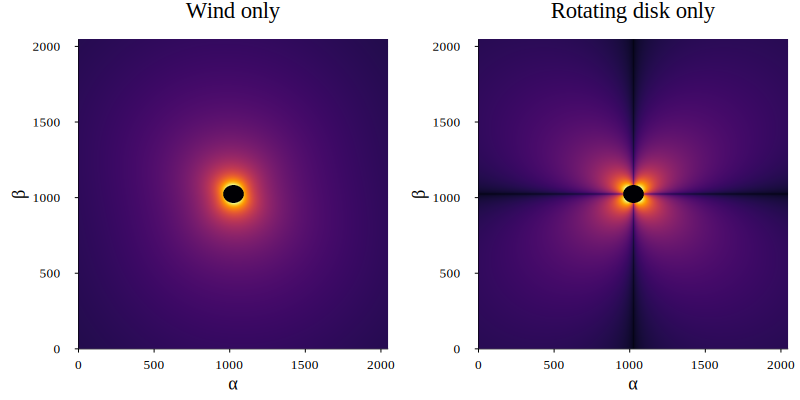

In [106]:
#sample calc
γ = 1; A0 = 1; τ = 10 
φn = φ .+ π/2 #+π/2 because we are different than CM by 90 deg; should this be -π/2 from analytic math??
∇vWind = dvldl(r,sini,φn,1) #φTerm only has wind component
∇vDisk = dvldl(r,sini,φn) #φTerm only has disk component

A = getA(A0,r,γ)

#calculate intensities for both cases
IWind = intensity(A,r,∇vWind,τ); IDisk = intensity(A,r,∇vDisk,τ)
IWind[r.<rMin] .= 0.; IDisk[r.<rMin] .= 0. #set intensities to zero inside the inner edge of disk we hard-coded above
default(widen=false,tickdirection=:out,fontfamily="times")
pWind=heatmap((IWind').^(1/4),aspect_ratio=:equal,colorbar=false,xlims=(0,nx),ylims=(0,ny),title="Wind only",xlabel="α",ylabel="β"); 
pDisk=heatmap((IDisk').^(1/4),aspect_ratio=:equal,colorbar=false,xlims=(0,nx),ylims=(0,ny),title="Rotating disk only",xlabel="α",ylabel="β") #always plot transpose in Julia to match Python, row vs col major
plot(pWind,pDisk,size=(800,400),left_margin=5*Plots.Measures.mm) #matches what we had in Python notebook

# Line profile sample

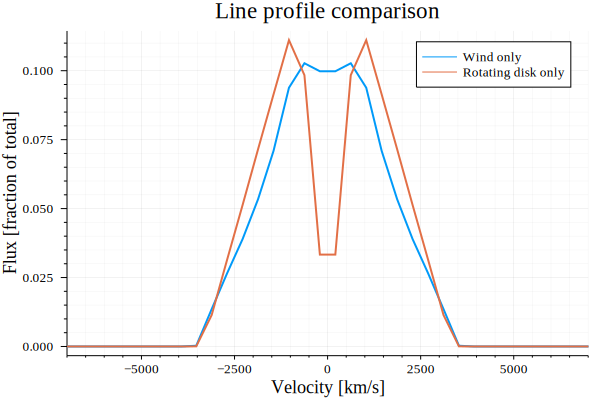

In [107]:
#now let's make plots of line profiles, flux vs velocity (proxy for λ) for both cases
#disk should be double peaked from rotation but wind should have most emission near v = 0 so should be single peaked
# plot((vec(ν).-1).*3e5,vec(IWind)./sum(vec(IWind))) #need to use this dumb binned statistic thing but can't figure out how to do it by hand, really annoyed
# plot((vec(ν).-1).*3e5,vec(IDisk)./sum(vec(IDisk)))

using PyCall
scipyStats = pyimport("scipy.stats"); binnedStat = scipyStats.binned_statistic #admitting defeat and just using stupid Python way
bins = 100
fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
plot((νBin.-1).*3e5,fluxW./sum(fluxW),label="Wind only",lw=2) #ν was a ratio, so subtract one to "center" it and multiply by c 
plot!((νBin.-1).*3e5,fluxD./sum(fluxD),label="Rotating disk only",lw=2)
plot!(xlims=(-7e3,7e3),widen=true,minorticks=true,minorgrid=true,title="Line profile comparison",xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]")
#matches Python notebook

# Generalizing 

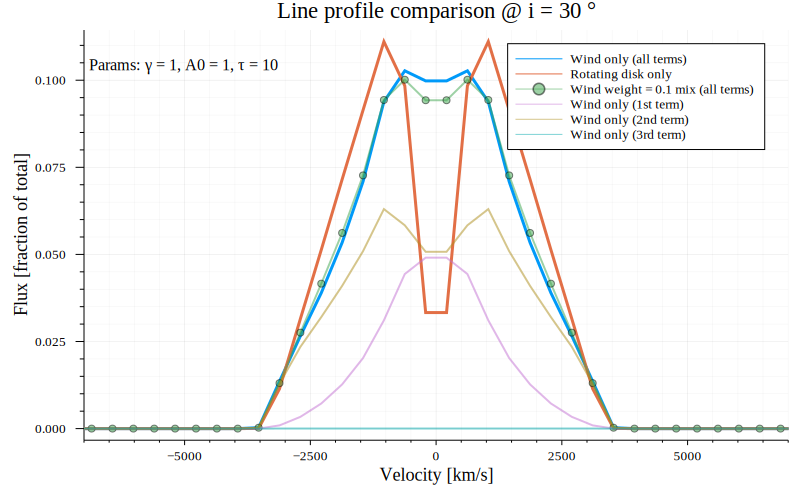

In [129]:
function setup(i=75,nx=2048,ny=2048,rlim=3e4)
    #set up "camera" with coordinates (x,y) = α,β ; inclined 75 deg from pole
    a = range(0,stop=nx-1,length=nx)./(nx-1)*rlim.-rlim/2; b = range(0,stop=ny-1,length=ny)./(ny-1)*rlim.-rlim/2

    meshgrid(x,y) = (repeat(x,outer=length(y)), repeat(y,inner=length(x)))
    α,β = meshgrid(a,b) 

    i = i/180*π; cosi = cos(i); sini = sin(i) #inclination angle in rad

    # calculate the raal and azimuthal coordinates wher rays sent from camera pixels intersect the "disk" in the equatorial plane, working back from camera
    r = reshape(sqrt.(β.^2 ./cosi^2 .+ α.^2),nx,ny); φ = reshape(atan.(β,α.*cosi),nx,ny) 
    ν = 1 .+ sqrt.(1 ./(2 .*r)).*sini.*cos.(φ) #Doppler shift G = M = c = 1; unclear why 2?
    return α,β,r,ν,φ,sini
end

function getIntensity(r,φ,windWeight,sini,rMin=1e3,γ=1,A0=1,τ=10; f1=1,f2=1,f3=1)
    φn = φ .+ π/2 #+π/2 because we are different than CM by 90 deg
    ∇v = dvldl(r,sini,φn,windWeight,f1,f2,f3)
    A = getA(A0,r,γ)
    #calculate intensities
    I = intensity(A,r,∇v,τ); I[r.<rMin] .= 0.
    return I,γ,A0,τ
end

function plotProfile(ν,I,IWind,IWind1,IWind2,IWind3,IDisk,windWeight,i,γ,A0,τ,bins=100)
    scipyStats = pyimport("scipy.stats"); binnedStat = scipyStats.binned_statistic #admitting defeat and just using stupid Python way
    fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
    fluxW1,νEdges,n=binnedStat(vec(ν),vec(IWind1),statistic="sum",bins=bins)
    fluxW2,νEdges,n=binnedStat(vec(ν),vec(IWind2),statistic="sum",bins=bins)
    fluxW3,νEdges,n=binnedStat(vec(ν),vec(IWind3),statistic="sum",bins=bins)
    fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
    flux,νEdges,n=binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
    p=plot((νBin.-1).*3e5,fluxW./sum(fluxW),label="Wind only (all terms)",lw=3)
    p=plot!((νBin.-1).*3e5,fluxD./sum(fluxD),label="Rotating disk only",lw=3)
    p=plot!((νBin.-1).*3e5,flux./sum(flux),label="Wind weight = $windWeight mix (all terms)",lw=2,α=0.5,marker=:dot)
    p=plot!((νBin.-1).*3e5,fluxW1./sum(fluxW),label="Wind only (1st term)",lw=2,α=0.5)
    p=plot!((νBin.-1).*3e5,fluxW2./sum(fluxW),label="Wind only (2nd term)",lw=2,α=0.5)
    p=plot!((νBin.-1).*3e5,fluxW3./sum(fluxW),label="Wind only (3rd term)",lw=2,α=0.5)
    p=plot!(xlims=(-7e3,7e3),widen=true,minorticks=true,minorgrid=true,title="Line profile comparison @ i = $i °",xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]")
    p=annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ","times",10,"black",:left)))
    return p
end

#a test
function main(i=75,windWeight=0.5)
    α,β,r,ν,φ,sini = setup(i)
    IWind,γ,A0,τ = getIntensity(r,φ,1,sini); IDisk,γ,A0,τ = getIntensity(r,φ,0,sini)
    IWind1,γ,A0,τ = getIntensity(r,φ,1,sini,f1=1,f2=0,f3=0)
    IWind2,γ,A0,τ = getIntensity(r,φ,1,sini,f1=0,f2=1,f3=0)
    IWind3,γ,A0,τ = getIntensity(r,φ,1,sini,f1=0,f2=0,f3=1)
    I,γ,A0,τ = getIntensity(r,φ,windWeight,sini)
    p = plotProfile(ν,I,IWind,IWind1,IWind2,IWind3,IDisk,windWeight,i,γ,A0,τ)
    return p
end
p = main(30,0.1)
plot(p,size=(800,500),left_margin=5*Plots.Measures.mm,bottom_margin=5*Plots.Measures.mm)µ

In [123]:
x = getIntensity(r,φ,0.5,sini); y= getIntensity(r,φ,1,sini)
x.==y

(false, true, true, true)

In [7]:
#interactive plot, kinda gimmicky
using Interact
i=spinbox([0,90],label="i",value=75)
windWeight=spinbox([0,1],label="wind weight",value=0.5)
interact = map(main,i,windWeight)
vbox(
    hbox(i,windWeight),
    interact)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7585891011555165475\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9042869600364798387\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7585891011555165475\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:attributes => Dict{Any, Any}(:type => "number", Symbol("data-bind") => "numericValue: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}"), :placeholder => [0, 90], :className => "input ", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "value" => (Observable{Union{Nothing, Int64}} with 2 listeners. Value:
75, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/home/kirk/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "value" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"value\"]()) ? (this.valueFromJulia[\"value\"]=true, this.model[\"value\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe61af75270, Task (runnable) @0x00007fe61af75270), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"2547881727824652954\",\"id\":\"13007742057733744722\",\"type\":\"observable\"}),\"value\":WebIO.getval({\"name\":\"value\",\"scope\":\"2547881727824652954\",\"id\":\"17039867085264414316\",\"type\":\"observable\"})};\n    var self = this;\

# What does this show?

Using just the terms in Waters+ 2016 we see replicate the results in CM96 &mdash; that the contribution of a "disk wind" term to the line profile is significant, even at relatively low weights, and can produce broad, single-peaked line profiles at a variety of inclination angles. 

## next steps

1. re-do photocenter calculations (see other notebook)

2. add line profile data to plot and fit, return best fit parameters &mdash <span style="color:red">data done below! should use Mamba MCMC to fit?</span>

3. add new terms to line of sight velocity gradient (gross math).

# Comparing to data

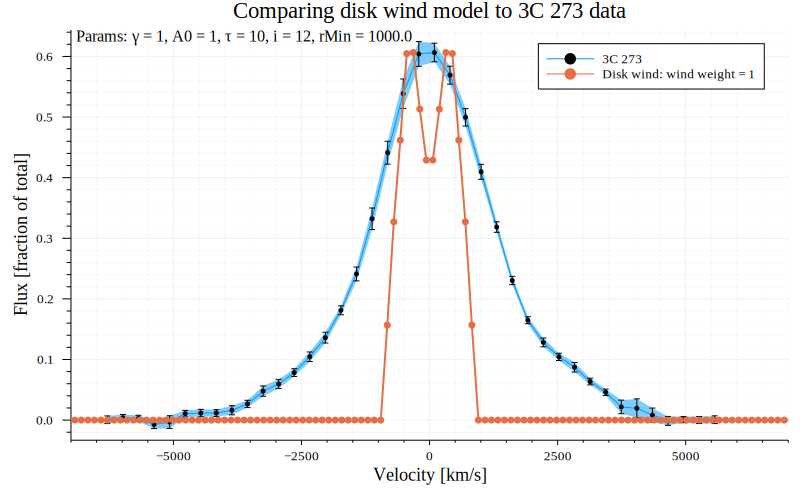

In [65]:
using PyCall, Plots.Measures
@pyimport pickle

function readPickle(file)
    data = nothing
    @pywith pybuiltin("open")(file,"rb") as f begin
        data = pickle.load(f,encoding="latin1")
    end
    return data
end

data = readPickle("3c273_juljanmarmay_append_gilles_specirf_wide_v6.p")
λCen = 2.172
vel = (data[1].-λCen)./λCen.*3e5
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))

i = 12; rMin = 2.5*1e3; windWeight = 1; bins = 150 #150 good visual match to data point spacing

α,β,r,ν,φ,sini = setup(i)
I,γ,A0,τ = getIntensity(r,φ,windWeight,sini,2.5*1e3)
flux,νEdges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])

p = plot!((νBin.-1).*3e5,flux./maximum(flux)*maximum(data[4]),marker=:circle,markerstrokewidth=0,label="Disk wind: wind weight = $windWeight",lw=2)
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $i, rMin = $rMin","times",10,"black",:left)))
plot(p,left_margin=5*Plots.Measures.mm,bottom_margin=5*Plots.Measures.mm)

In [9]:
#interactive version
using Interact
function interactData(i=75,rMin=1e3,windWeight=1,bins=100)
    data = readPickle("3c273_juljanmarmay_append_gilles_specirf_wide_v6.p")
    λCen = 2.172
    vel = (data[1].-λCen)./λCen.*3e5
    p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
    p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
    α,β,r,ν,φ,sini = setup(i)
    I,γ,A0,τ = getIntensity(r,φ,windWeight,sini,rMin)
    flux,νEdges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
    p = plot!((νBin.-1).*3e5,flux./maximum(flux)*maximum(data[4]),label="Disk wind: wind weight = $windWeight",lw=2)
    p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $i, rMin = $rMin","times",10,"black",:left)))
    plot(p,left_margin=5*Plots.Measures.mm,bottom_margin=5*Plots.Measures.mm)
end

i=spinbox([0,90],label="i",value=75)
windWeight=spinbox([0,1],label="wind weight",value=1)
rMin=spinbox(label="rMin",value=1e3)
bins=spinbox(label="bins",value=100)
interact = map(interactData,i,rMin,windWeight,bins)
vbox(
    hbox(i,windWeight),
    hbox(rMin,bins),
    interact)

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:attributes => Dict{Any, Any}(:type => "number", Symbol("data-bind") => "numericValue: value, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}"), :placeholder => [0, 90], :className => "input ", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}())], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "value" => (Observable{Union{Nothing, Int64}} with 2 listeners. Value:
75, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/kirk/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/home/kirk/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/home/kirk/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "value" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"value\"]()) ? (this.valueFromJulia[\"value\"]=true, this.model[\"value\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe5a0f5cbe0, Task (runnable) @0x00007fe5a0f5cbe0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12026605648816455579\",\"id\":\"3059216856293405284\",\"type\":\"observable\"}),\"value\":WebIO.getval({\"name\":\"value\",\"scope\":\"12026605648816455579\",\"id\":\"5617226325883431546\",\"type\":\"observable\"})};\n    var self = this;\

# Finding best fits

**Important: Need to fit phases and spectrum at once!**

Start with `windWeight=1` and fit `rMin`, `i`, and `M` to model. Can try LSQ (maybe will work better once mass added in?) but probably need to sort out MCMC, might bail to Python? Can write my own also, not that hard. 

In [81]:
using AffineInvariantMCMC #this is equivalent to Python's emcee package, check with Aimee on this -- WIP

numdims = 5
numwalkers = 100
thinning = 10
numsamples_perwalker = 1000
burnin = 100

const stds = exp.(5 .* randn(numdims))
const means = 1 .+ 5 .* rand(numdims)
llhood = x->begin
	retval = 0.
	for i in 1:length(x)
		retval -= .5 * ((x[i] - means[i]) / stds[i]) ^ 2
	end
	return retval
end
x0 = rand(numdims, numwalkers) .* 10 .- 5
chain, llhoodvals = AffineInvariantMCMC.sample(llhood, numwalkers, x0, burnin, 1)
chain, llhoodvals = AffineInvariantMCMC.sample(llhood, numwalkers, chain[:, :, end], numsamples_perwalker, thinning)
flatchain, flatllhoodvals = AffineInvariantMCMC.flattenmcmcarray(chain, llhoodvals)
flatchain

5×10000 Matrix{Float64}:
 -6.8868    2.40364  -1.38711   1.01103   1.63911  …  -654.998      922.469
  3.74192   3.74185   3.74198   3.74149   3.7418         3.742        3.74198
 38.4373   -1.36204  11.9754    3.03224   1.21162     7129.37     -4007.35
 14.4085   -2.52847   8.17685  -1.95744  -2.33641        4.56589      2.62989
  3.14748   3.14744   3.1474    3.14692   3.14723        3.14751      3.1474

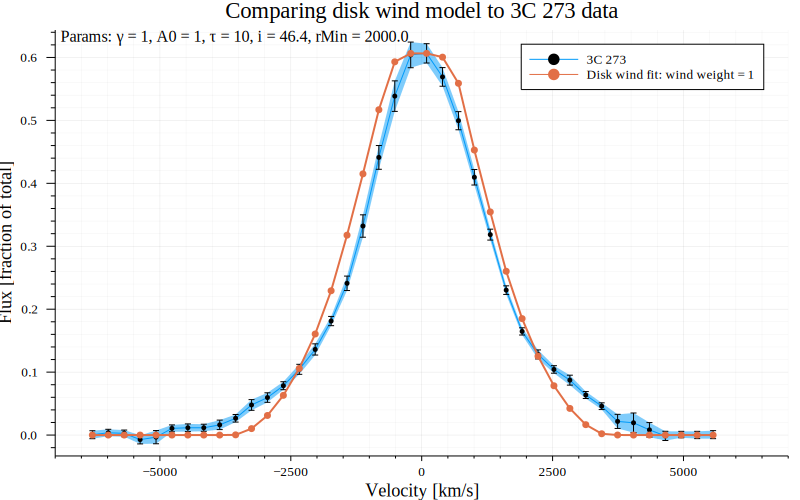

In [8]:
#least squares until I figure above out? turns out this is hard also -- this doesn't do anything it just converges to whatever it started with, actually it does do something sometimes..?
using LsqFit, SimplePCHIP
#generate fit function by interpolating among the bins, so that it's a function of "x" (v)
#then minimize that along the data points?
function lineProfile(ν,params,data=data) #incredibly inefficient to calculate the full thing at each step, but otherwise need to go back to beginning and setup differently?
    i,rMin = params
    α,β,r,νloc,φ,sini = setup(i) #this ν is discrete, we will interpolate to make it continuous for fitting
    I,γ,A0,τ = getIntensity(r,φ,1,sini,rMin) #use maximal wind case
    flux,νEdges,n = binnedStat(vec(νloc),vec(I),statistic="sum",bins=150)
    νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1]) #still discrete
    x = (νBin.-1).*3e5; y = flux./maximum(flux).*maximum(data[4])
    interp = SimplePCHIP.interpolate(x,y) #returns functional form of line profile from interpolation
    return interp.(ν) #this is the interpolated value as a fx of any ν
end

test = lineProfile(3000,(75,1e3))
νRange = range(-5000,stop=5000,length=100) #takes ~30 sec for 100 pts
p0 = [50,2e3]
vel = (data[1].-λCen)./λCen.*3e5
fit = curve_fit(lineProfile,vel,data[4],p0)
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
p = plot!(vel,lineProfile(vel,fit.param),marker=:circle,markerstrokewidth=0,label="Disk wind fit: wind weight = $windWeight",lw=2)
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $(round(fit.param[1],sigdigits=3)), rMin = $(round(fit.param[2],sigdigits=3))","times",10,"black",:left)))

In [107]:
#let's write a shitty MC routine by hand to sample the distrubtion of possible fit "solutions" -- takes like 2 hours to run, not that informative? maybe will let run longer
function shittyMC(p0,perturb,data,maxIter=100,nWalk=10,pSwitch=0.01,converge=0.001)
    solutions = Array{typeof(Array{Float64,1}(undef,length(p0))),1}(undef,nWalk) #initialize array
    i0,rMin0 = p0; pi,prMin = perturb
    for n=1:nWalk
        println("walker $n/$nWalk")
        converged = false; iter = 1
        signi = rand() < 0.5 ? -1 : 1; signr = rand() < 0.5 ? -1 : 1
        i,rMin = i0+signi*pi,rMin0+signr*prMin #initial nudges from guess, should convert to random draws from range to explore more of parameter space?
        while converged == false && iter < maxIter
            vel = (data[1].-λCen)./λCen.*3e5
            iNew,rMinNew = curve_fit(lineProfile,vel,data[4],[i,rMin]).param
            Δi = abs(iNew-i)/i; Δr = abs(rMinNew-rMin)/rMin
            if Δi < converge || Δr < converge || iter == maxIter-1
                i = iNew; rMin = rMinNew
                solutions[n] = [i,rMin]
                converged == true
            else
                signi = sign(iNew-i); signr = sign(rMinNew-rMin)
                i = iNew + signi*pi; rMin = rMinNew + signr*prMin
                if rand() < pSwitch #occasionally randomly try switching directions
                    i = iNew + -1*signi*pi
                end
                if rand() < pSwitch #keep r decision independent of i
                    rMin = rMinNew + -1*signr*prMin
                end
            end
            iter += 1
        end
    end
    return solutions
end
solutions = shittyMC(p0,[10,100],data)

initialized array
walker 1/10
walker 2/10
walker 3/10
walker 4/10
walker 5/10
walker 6/10
walker 7/10
walker 8/10
walker 9/10
walker 10/10


10-element Vector{Vector{Float64}}:
 [50.205275041754575, 1986.6216338640884]
 [60.103112864811855, 2098.6374051157786]
 [60.103112864811855, 2098.6374051157786]
 [59.67476157152693, 1900.0112949314735]
 [50.205275041754575, 1986.6216338640884]
 [59.67476157152693, 1900.0112949314735]
 [40.005977264755586, 1900.0]
 [40.005977264755586, 1900.0]
 [40.005977264755586, 1900.0]
 [60.103112864811855, 2098.6374051157786]

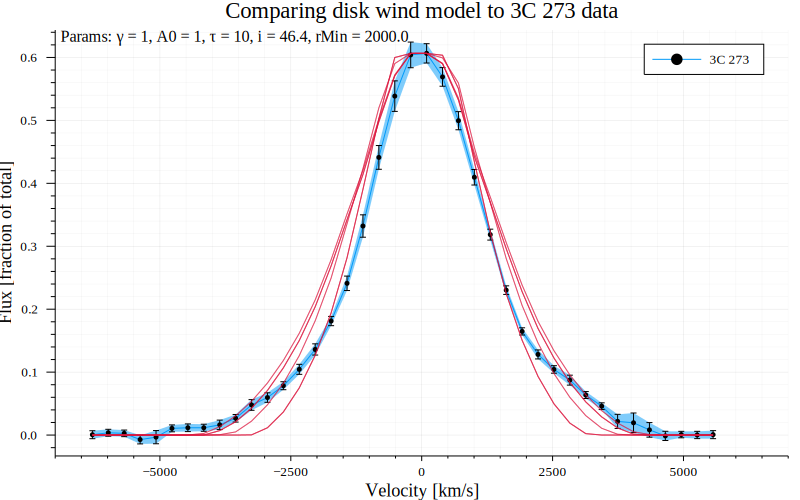

In [112]:
p = plot(vel,data[4],ribbon=data[7],yerr=data[7],marker=:circle,markercolor=:black,markersize=3,label="3C 273")
p = plot!(widen=true,minorgrid=true,xlabel="Velocity [km/s]",ylabel="Flux [fraction of total]",title="Comparing disk wind model to 3C 273 data",size=(800,500),xlims=(-7e3,7e3))
for soln in solutions
    p = plot!(vel,lineProfile(vel,soln),markerstrokewidth=0,label="",lw=1,linealpha=0.5,c=:crimson)
end
p = annotate!((-6900,ylims(p)[2]-0.01,Plots.text("Params: γ = $γ, A0 = $A0, τ = $τ, i = $(round(fit.param[1],sigdigits=3)), rMin = $(round(fit.param[2],sigdigits=3))","times",10,"black",:left)))

# Centroid and phase calculations

In [66]:
function centroid(ν,I,α,β,bins=100)
    xcen,edges,n = binnedStat(vec(ν),vec(I.*α),statistic="sum",bins=bins) #element-wise multiplication to get x/α
    ycen,edges,n = binnedStat(vec(ν),vec(I.*β),statistic="sum",bins=bins) #same but for y/β
    iSum,edges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins) #just total intensty binning
    iSum[iSum.==0.].=1. #it's zero less than rMin, but set to 1 because going to divide
    return xcen./iSum, ycen./iSum #centroids in x/α, y/β, binned along 100 (by default) bins in ν
end

function phase(ν,I,x,y,U,V,bins=100)
    #shape of I is the problem here
    dφMap = @. -2*π*(x*U+y*V)*I*180/π*1e6 #1e6 is units of u,v 180/π to convert rad to deg, gives us corresponding dφ at every ν bin
    dφ,edges,n = binnedStat(vec(ν),vec(dφMap),statistic="sum",bins=bins) #phase binned along ν
    iSum,edges,n = binnedStat(vec(ν),vec(I),statistic="sum",bins=bins) #binned total I
    iSum[iSum.==0.].=1. #set to 1 in places beneath rMin so that we don't divide by 0
    return dφ./iSum
end

phase (generic function with 2 methods)

In [67]:
#check phases
i=12; windWeight=1; rMin=2.5e3
α,β,r,ν,φ,sini = setup(i); I,γ,A0,τ = getIntensity(r,φ,windWeight,sini,2.5*1e3)
U = [60.,45.,0.]; V = [0.,45.,60.]; blRange=3e8*2e33*6.67e-8/9e20/548/3.09e24 #3e8MSun*g/msun*G/c^2 (cgs) / Jason says Angular size (Mpc) / Mpc (cm) -> [blrange] = rad; u,v (NOT nu) telescope baselines in units of λ
#GM/c^2 D is a dimensionless number, fitting for M is changing 3e8 number essentially
x=reshape(α.*blRange,(nx,ny)); y=reshape(β.*blRange,(nx,ny)); dφList = [] #each index will have maximal wind case + rotation only case
IWind,γ,A0,τ = getIntensity(r,φ,1,sini,rMin); IDisk,γ,A0,τ = getIntensity(r,φ,0,sini,rMin)
for i=1:length(U)
    push!(dφList,(phase(ν,IWind,x,y,U[i],V[i]),phase(ν,IDisk,x,y,U[i],V[i]))) #this depends on M through x,y should be fit
end

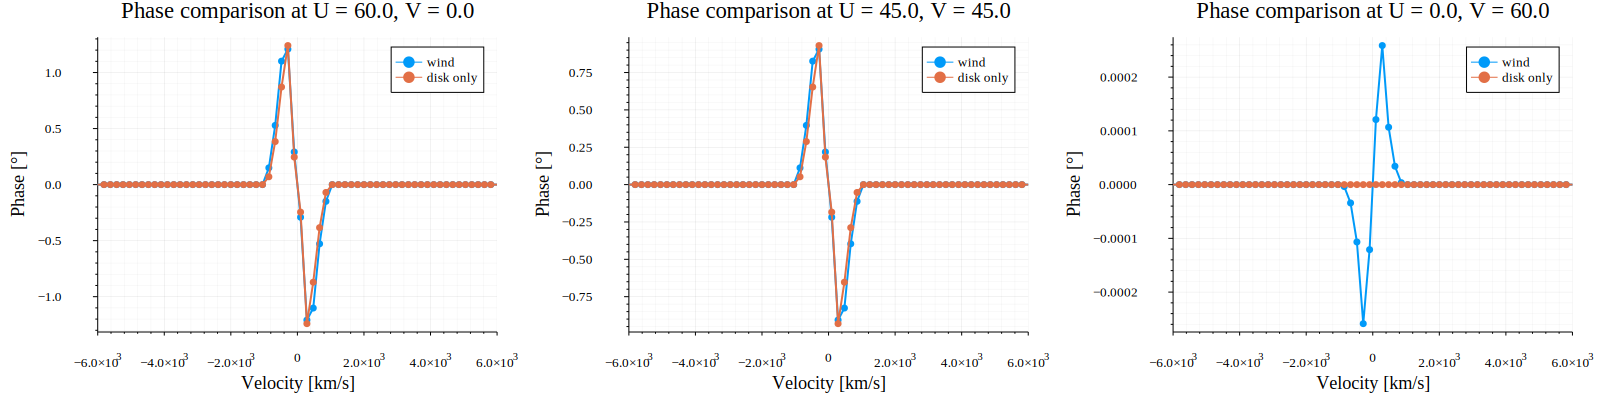

In [68]:
#fline=spec/np.max(spec)*0.6/(1.+spec/np.max(spec)*0.6)
bins = 100
fluxW,νEdges,n=binnedStat(vec(ν),vec(IWind),statistic="sum",bins=bins)
fluxD,νEdges,n=binnedStat(vec(ν),vec(IDisk),statistic="sum",bins=bins)
νBin = 0.5*(νEdges[2:end].+νEdges[1:end-1])
flineD = fluxD./maximum(fluxD)*0.6./(1 .+ fluxD./maximum(fluxD).*0.6) #is this the mass??
flineW = fluxW./maximum(fluxW)*0.6./(1 .+ fluxW./maximum(fluxW).*0.6)
function phasePlot(νBin,dφList,U,V,ind,flineW,flineD)
    p=plot((νBin.-1).*3e5,dφList[ind][1].*flineW,label="wind",lw=2,marker=:circle,markerstrokewidth=0)
    p=plot!((νBin.-1).*3e5,dφList[ind][2].*flineD,label="disk only",lw=2,marker=:circle,markerstrokewidth=0)
    p=plot!(title="Phase comparison at U = $(U[ind]), V = $(V[ind])",left_margin=5*Plots.Measures.mm,bottom_margin=5*Plots.Measures.mm,right_margin=5*Plots.Measures.mm,top_margin=5*Plots.Measures.mm)
    p=plot!(xlabel="Velocity [km/s]",ylabel="Phase [°]",minorgrid=true,minorticks=true,xlims=(-6e3,6e3),widen=true)
    return p
end
p1=phasePlot(νBin,dφList,U,V,1,flineW,flineD); p2=phasePlot(νBin,dφList,U,V,2,flineW,flineD); p3=phasePlot(νBin,dφList,U,V,3,flineW,flineD)
plot(p1,p2,p3,size=(1600,400),layout=@layout([a b c]),bottom_margin=10*Plots.Measures.mm,left_margin=10*Plots.Measures.mm)

In [70]:
#plotting phase data
# now what do the phases look like?
using Statistics
UData=data[2]; VData=data[3]; scipyNDImg = pyimport("scipy.ndimage"); G1D = scipyNDImg.gaussian_filter1d; dφList = []; psf=4e-3/2.35 #idk why this psf
for i=1:length(UData)
    for ii in [I]
#        dphi_map=-2.*np.pi*(x*u[i]+y*v[i])*ii*180./np.pi*1e6
#        dphi_avg,p_edges,p_n = binned_statistic(nu.flatten(),dphi_map.flatten(),statistic=‘sum’,bins=bins)
        dφAvgRaw=phase(ν,ii,x,y,UData[i],VData[i]) #phase(nu,ii,x,y,u[i],v[i],bins=bins)
        dφAvg = G1D(dφAvgRaw,psf/3e5/(νBin[2]-νBin[1])) #why psf/3e5/Δν ?
        push!(dφList,dφAvg)
    end
end

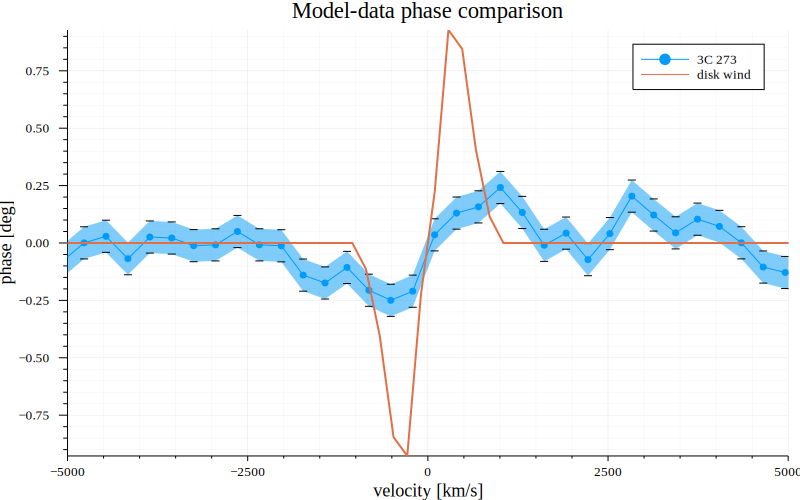

In [72]:
# radius factor chosen for best match to data; also means M_BH goes up by that factor
rfac=1.3
indx=[0,1,2,6,7,8,12,13,14,18,19,20].+1; oindx=[3,4,5,9,10,11,15,16,17,21,22,23].+1 #+1 to translate from Python code
#plt.errorbar(vel,np.mean(data[4][indx],axis=0),vel*0.+0.07,marker=‘o’,label=‘3C 273’)
p = plot(vel,mean(data[5][indx,:],dims=1)',yerr=vel.*0.0.+0.07,ribbon=vel.*0.0.+0.07,markerstrokewidth=0,label="3C 273",marker=:circle)
#plt.plot((nubin-1.)*3e5,np.mean(np.array(dphi)[indx],axis=0)*fline*rfac,linewidth=3,label=‘disk wind’)
p = plot!((νBin.-1).*3e5,mean(dφList[indx,:],dims=1)[1].*flineW*rfac,lw=2,label="disk wind")
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[::-1],labels[::-1],loc=‘upper left’)
#plt.plot((nubin-1.)*3e5,np.mean(np.array(dphi)[oindx],axis=0)*fline*rfac,linewidth=3)
#plt.axis([-5000,5000,-0.35,0.35])
p = plot!(xlims=(-5e3,5e3),xlabel="velocity [km/s]",ylabel="phase [deg]",minorgrid=true,minorticks=true,title="Model-data phase comparison",size=(800,500))
#plt.xlabel(‘velocity (km/s)’); plt.ylabel(‘phase (deg)’)

**Important queston:** In GRAVITY instrument paper they show sample plot of differential phase (pretty sure that's the same thing we have here) with wavelength (which velocity is proxy for here) and it shows "no differential phase signature ... despite a precision of roughly less than 1 degree". In that plot the phase just looks like random noise whereas here even in the wind case there is a clear double peak profile, albeit at margins smaller than 1 degree. Does this mean that this idea has already been ruled out observationally? 

**Answer:** No, that paper was just old, and in fact new results have shown this kind of profile at ~the amplitude we see here.

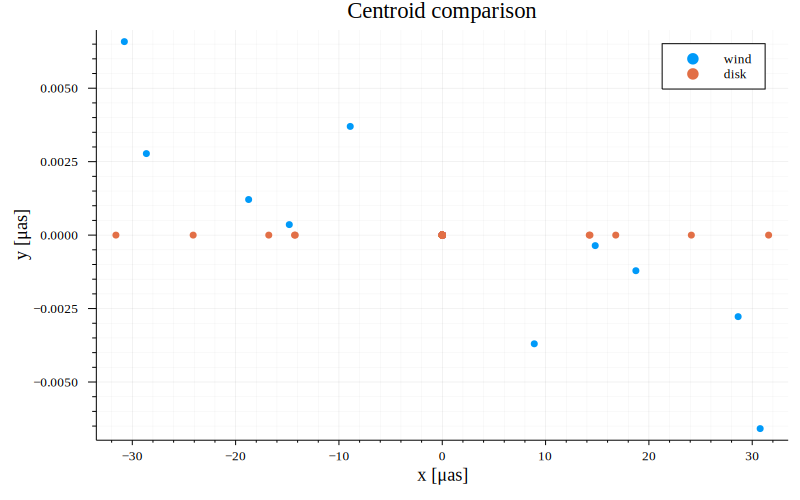

In [73]:
#first show all of them
α = reshape(α,(nx,ny)); β = reshape(β,(nx,ny))
xCWind,yCWind = centroid(ν,IWind,α,β)
xCDisk,yCDisk = centroid(ν,IDisk,α,β)
lim=2e4*blRange/4.85e-12 #think 2e4 should really be 3e4, corresponds to rlim before but now converting from units of r_s to μas, units of blrange = rad/r_s
#jason says the 4.85e-12 is rad to μas -- it is = 1/3600*π/180*1e-6
scatter(xCWind.*blRange/4.85e-12,yCWind.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,label="wind")
scatter!(xCDisk.*blRange/4.85e-12,yCDisk.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,label="disk")
plot!(xlabel="x [μas]",ylabel="y [μas]",minorgrid=true,minorticks=true,title="Centroid comparison",size=(800,500),bottom_margin=5*Plots.Measures.mm,left_margin=5*Plots.Measures.mm,widen=true)

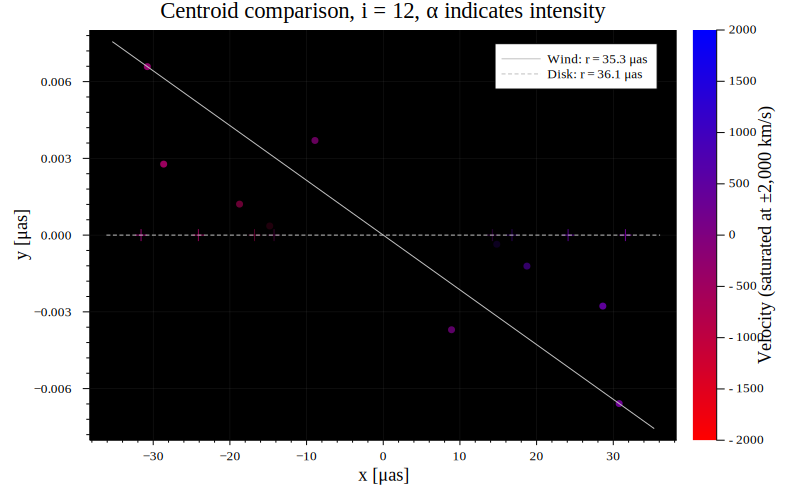

In [74]:
#now let's do a better version with blue/redshifts, the centroid inds should correspond to bins in νBin, should generalize functionally (same with above, maybe display side by side)
meanRW = sum(vec(IWind).*vec(r))/sum(vec(IWind))*blRange/4.85e-12; meanRD = sum(vec(IDisk).*vec(r))/sum(vec(IDisk))*blRange/4.85e-12 #mean weighted radii in μas
plot(xlabel="x [μas]",ylabel="y [μas]",minorgrid=true,minorticks=true,title="Centroid comparison, i = $i, α indicates intensity",size=(800,500),bottom_margin=5*Plots.Measures.mm,left_margin=5*Plots.Measures.mm,widen=true,
    colorbar_title="Velocity (saturated at ±2,000 km/s)",right_margin=5*Plots.Measures.mm,background_color_inside=:black,foreground_color_grid=:white)
scatter!(xCWind.*blRange/4.85e-12,yCWind.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,zcolor=((νBin.-1).*3e5),m=cgrad([:red,:blue],10),clim=(-2e3,2e3),
    label="",markeralpha=fluxW./maximum(fluxW))
scatter!(xCDisk.*blRange/4.85e-12,yCDisk.*blRange/4.85e-12,marker=:circle,markerstrokewidth=0,zcolor=((νBin.-1).*3e5),m=cgrad([:red,:blue],10),clim=(-2e3,2e3),
    label="",markershape=:cross,markersize=6,markeralpha=fluxD./maximum(fluxD))
tiltW = atan(minimum(xCWind),maximum(yCWind))
plot!([-meanRW*sin(tiltW),meanRW*sin(tiltW)],[-meanRW*cos(tiltW),meanRW*cos(tiltW)],label="Wind: r = $(round(meanRW,sigdigits=3)) μas",c=:silver)
plot!([-meanRD,meanRD],[0.,0.],label="Disk: r = $(round(meanRD,sigdigits=3)) μas",linestyle=:dash,c=:silver)


# New fitting approach: minimizing residuals from data in both phase and line fits

In [16]:
function getR(i,rMin,Mfac,windWeight=1) #get residuals from phase and line fit, but first we need to actually plot phase with data

LoadError: syntax: incomplete: premature end of input